<a href="https://colab.research.google.com/github/argmaxml/acoustic_similarity_dashboard/blob/master/kueez_tabular_trasnformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install comet_ml --quiet

In [2]:
import comet_ml

In [3]:
experiment = comet_ml.Experiment(
    api_key="gcWlyEttyEF95OqUkaMnTSZqN",
    project_name="kueez-google-bid-deep"
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/aviad-has/kueez-google-bid-deep/4366d085690c413f802669cbf0a89734



In [4]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_extraction import FeatureHasher



In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [6]:
def traffic_source(utm_source: str):
    try:
        if 'facebook' in utm_source or 'fb' in utm_source:
            return 'facebook'
        if 'twitter' in utm_source:
            return 'twitter'
        if 'google' in utm_source:
            return 'google'
        if 'pinterest' in utm_source:
            return 'pinterest'
        if 'snap' in utm_source:
            return 'snap'
        if 'tiktok' in utm_source:
            return 'tiktok'
        if 'outbrain' in utm_source:
            return 'outbrain'
        if 'tbl' in utm_source:
            return 'taboola'
    except:
        pass
    return 'Other'


def traffic_medium(utm_medium: str):
    try:
        if 'paid' in utm_medium or 'pd' in utm_medium:
            return 'paid'
        if 'org' in utm_medium or 'organic' in utm_medium or 'publish' in utm_medium:
            return 'organic'
        if 'aff' in utm_medium:
            return 'affiliate'
        if 'unknown' in utm_medium:
            return 'unknown'
    except:
        pass
    return 'Other'

In [7]:
def clean_data(df):
    # deleting all rows with bid < 0.06 in US and all rows with bid < 0.03 in other countries
    n_rows = df.shape[0]
    df = df[~((df['CountryCode'] == 'US') & (df['bid'] < 0.06) |
              (df['CountryCode'] != 'US') & (df['bid'] < 0.03))]
    # delete all rows with bid < max_2nd_bid
    df = df[df['bid'] >= df['max_2nd_bid']]
    n_rows_after = df.shape[0]
    print(f"Cleaning data: {n_rows - n_rows_after} rows deleted from total {n_rows} rows")
    return df

In [8]:
seed = 422
keras.utils.set_random_seed(
    seed
)
experiment.log_parameter("seed", seed)

In [9]:
source_cat = {
    'google' : ['google'],
    'facebook' : ['facebook'],
    'outbrain' : ['outbrain', 'Other', "pinterest"]
}
sizes = ['high', 'low']

def read_data_grouped_train(dir_name):
    test_df = {value : {group_name : pd.read_csv(f'{dir_name}/sampled_1M_{value}_{group_name}.csv.gz', low_memory=False) for group_name in source_cat.keys()} for value in sizes}
    return test_df

# group_df_train = read_data_grouped_train('/content')
# data = pd.concat([group_df_train[value][group_name] for value in sizes for group_name in source_cat])


In [10]:
data = pd.read_csv('/content/prediction_latest_raw_data_normalized.000000000289.csv.gz')
data = pd.concat([data, pd.read_csv('/content/prediction_latest_raw_data_normalized.000000000288.csv.gz')])
data = pd.concat([data, pd.read_csv('/content/prediction_latest_raw_data_normalized.000000000287.csv.gz')])



In [11]:
data.shape
experiment.log_parameter("data.shape", data.shape)

In [12]:
data.isna().sum()

EventTimeUsec2          0
SessionDepth            0
Region              45513
RefererURL              0
platform           384044
source_medium           0
OS                      0
Browser                10
CountryCode             0
mb_site_id        2256536
mbid                23850
hb_bidder          353045
pb_bid                  0
amzn_bid                0
bf_bidder               0
bid                     0
dtype: int64

In [13]:
data = data.drop('mb_site_id', axis=1)

In [14]:
data.isna().sum()

EventTimeUsec2         0
SessionDepth           0
Region             45513
RefererURL             0
platform          384044
source_medium          0
OS                     0
Browser               10
CountryCode            0
mbid               23850
hb_bidder         353045
pb_bid                 0
amzn_bid               0
bf_bidder              0
bid                    0
dtype: int64

In [15]:
data = data.fillna("0")

In [16]:
data.isna().sum()

EventTimeUsec2    0
SessionDepth      0
Region            0
RefererURL        0
platform          0
source_medium     0
OS                0
Browser           0
CountryCode       0
mbid              0
hb_bidder         0
pb_bid            0
amzn_bid          0
bf_bidder         0
bid               0
dtype: int64

In [17]:
data['max_2nd_bid'] = np.max([data['pb_bid'], data['amzn_bid']], axis=0)
data = clean_data(data)
data['source'] = data['source_medium'].apply(traffic_source)
data['medium'] = data['source_medium'].apply(traffic_medium)
data['epoch'] = data['EventTimeUsec2'] // 1000000

Cleaning data: 14787 rows deleted from total 2693441 rows


In [18]:
data.loc[data['CountryCode'] == 'us', 'State'] = data.loc[data['CountryCode'] == 'us', 'Region']
data.loc[data['CountryCode'] != 'us', 'State'] = 'unknown'

In [20]:
us_state_tz = pd.read_csv('/content/US_state_tz.csv')


In [21]:
more_states = pd.DataFrame({'state': ["San Francisco Bay Area", "District of Columbia", "Silicon Valley"],	
                            'abbr': ["SF", "DC", "SV"],	
                            'tz': ["EST", "EST", "PST"],
                            'utc_diff': [-7, -4, -7]}, 
                            index=[len(us_state_tz), len(us_state_tz)+1, len(us_state_tz)+2])

us_state_tz = pd.concat([us_state_tz, more_states])

In [22]:
us_state_tz_dict = {state :utc_diff for state, utc_diff in us_state_tz[['state', 'utc_diff']].itertuples(index=False)}
us_state_tz_dict['Alaska']

-9

In [23]:
# remove all rows CountryCode == 'us' and State is not in us_state_tz
data = data.loc[~((data['CountryCode'] == 'us') & ~(data['State'].isin(us_state_tz['state']))), :]

In [24]:
from datetime import datetime, timedelta
import pytz


def convert_epoch_to_local_hour(epoch, country_code, state):
    if country_code == 'us':
        utc_time = datetime.fromtimestamp(epoch, tz=pytz.timezone('UTC'))
        hour_offset = int(us_state_tz_dict[state])
        time_offset = timedelta(hours=hour_offset)
        local_time = utc_time + time_offset
        return local_time.hour
    else:
        if timezone := pytz.country_timezones.get(country_code.upper()):
            timezone = timezone[0]
        else:
            timezone = 'UTC'
    return datetime.fromtimestamp(epoch, tz=pytz.timezone(timezone)).hour



In [25]:
def time_features(df):
    df['local_hour'] = df.apply(lambda x: convert_epoch_to_local_hour(x['epoch'], x['CountryCode'], x['State']), axis=1)
    df['weekday'] = df['epoch'].apply(lambda x: datetime.fromtimestamp(x).weekday()).astype('category')
    df['is_weekend'] = ((df['weekday'] == 5) | (df['weekday'] == 6)).astype('category')
    df['part_of_day'] = (df['local_hour'] // 6).astype('category')
    df['utc_hour'] = df['epoch'].apply(lambda x: datetime.fromtimestamp(x, tz=pytz.timezone('UTC')).hour)
    return df


In [26]:
data = time_features(data)

In [27]:
higher_bid_is_outlier = 20
data = data[data['bid'] < higher_bid_is_outlier]
experiment.log_parameter("higher_bid_is_outlier", higher_bid_is_outlier)

In [28]:
data[data['max_2nd_bid'] <= 0.9].shape[0] / data.shape[0]

0.9063692105866765

In [29]:
# data = data[data['max_2nd_bid'] <= 0.9]

In [30]:
train_data, test_data = train_test_split(data, test_size=0.2)


In [31]:
test_data['bid'].max()

19.953

In [32]:
numeric_features = ['SessionDepth', 'pb_bid','amzn_bid','max_2nd_bid']
# numeric_features = ['SessionDepth']

In [33]:
# Normalize the numeric features
scaler = StandardScaler()
numeric_features_scale = [f'{feature}_sc' for feature in numeric_features]
train_data[numeric_features_scale] = scaler.fit_transform(train_data[numeric_features])
test_data[numeric_features_scale] = scaler.transform(test_data[numeric_features])

experiment.log_parameter("scaler", str(scaler))

In [34]:
train_data['ratio'] = train_data['bid'] / np.maximum(train_data['max_2nd_bid'], 0.0001)
test_data['ratio'] = test_data['bid'] / np.maximum(test_data['max_2nd_bid'], 0.0001)

In [35]:
scaler_y =  StandardScaler()
train_data['bid_sc'] = scaler_y.fit_transform(train_data['bid'].values.reshape(-1, 1))
test_data['bid_sc'] = scaler_y.transform(test_data['bid'].values.reshape(-1, 1))
experiment.log_parameter("scaler_y", str(scaler_y))

# train_data['ratio_sc'] = scaler_y.fit_transform(train_data['ratio'].values.reshape(-1, 1))
# test_data['ratio_sc'] = scaler_y.transform(test_data['ratio'].values.reshape(-1, 1))

In [36]:
data['bf_bidder'].value_counts()

adx     2381376
ebda     291153
Name: bf_bidder, dtype: int64

In [37]:
categorical = ['Browser', 'CountryCode','State', 'OS', 'RefererURL', 'source', 'platform', 'medium', 'hb_bidder','bf_bidder', 'weekday', 'is_weekend', 'part_of_day','utc_hour', 'local_hour']
numeric = ['SessionDepth', 'pb_bid', 'amzn_bid','max_2nd_bid']
train_columns = categorical + numeric_features_scale
target_column = 'bid_sc'
# target_column = 'ratio_sc'
experiment.log_parameter("train_columns", train_columns)
experiment.log_parameter("target_column", target_column)


In [38]:
# Separate the features and the labels
train_features = train_data[train_columns]
train_labels = train_data[target_column]


In [39]:
test_features = test_data[train_columns]
test_labels = test_data[target_column]


In [40]:
train_features.dtypes

Browser              object
CountryCode          object
State                object
OS                   object
RefererURL           object
source               object
platform             object
medium               object
hb_bidder            object
bf_bidder            object
weekday            category
is_weekend         category
part_of_day        category
utc_hour              int64
local_hour            int64
SessionDepth_sc     float64
pb_bid_sc           float64
amzn_bid_sc         float64
max_2nd_bid_sc      float64
dtype: object

In [41]:
# Encode the categorical features
# train_features_org = train_features.copy()
# train_features = train_features[numeric_features]

# test_features_org = test_features.copy()
# test_features = test_features[numeric_features]

le = {}
for column in categorical:
    print(column)
    le[column] = LabelEncoder()
    le[column].fit(data[column])
    train_features[column] = le[column].transform(train_features[column])
    test_features[column] = le[column].transform(test_features[column])
experiment.log_parameter("categorical_encoder", str(le[column]))

Browser


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


CountryCode


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


State


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


OS


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


RefererURL


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


source


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


platform


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


medium


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


hb_bidder


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


bf_bidder


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


weekday


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


is_weekend


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


part_of_day


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


utc_hour


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


local_hour


<ipython-input-41-b5f8c00aad97>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_features[column] = le[column].transform(train_features[column])
<ipython-input-41-b5f8c00aad97>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features[column] = le[column].transform(test_features[column])


In [86]:
embd_dict

{'Browser': 3,
 'CountryCode': 8,
 'State': 4,
 'OS': 2,
 'RefererURL': 6,
 'source': 2,
 'platform': 2,
 'medium': 2,
 'hb_bidder': 3,
 'bf_bidder': 2,
 'weekday': 2,
 'is_weekend': 2,
 'part_of_day': 2,
 'utc_hour': 3,
 'local_hour': 3}

In [90]:
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, BatchNormalization, Dropout, MultiHeadAttention, Add, LayerNormalization, Flatten, concatenate


In [91]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(Dense(units, activation=activation))
        mlp_layers.append(Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [96]:
# Build the model v0
# model = keras.Sequential([
#     keras.layers.Dense(64, activation='relu', input_shape=[len(train_features.columns)]),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.Dense(1)
# ])

WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.4

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 6  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.


number_dict = {cat : data[cat].nunique() for cat in categorical}
# embd_dict = {cat : max(2, int(np.sqrt(data[cat].nunique()))//2+1) for cat in categorical}
embd_dict = {cat : 6 for cat in categorical}

# Define input layers for categorical features
categorical_inputs = []
embedding_layers = []

for feature in categorical:
    num_unique_values = number_dict[feature]
    embedding_size = embd_dict[feature]

    input_layer = keras.layers.Input(shape=(), name=f'{feature}_input')
    categorical_inputs.append(input_layer)

    embedding_layer = keras.layers.Embedding(input_dim=num_unique_values, output_dim=embedding_size, name=f"{feature}_emb")(input_layer)
    embedding_layers.append(embedding_layer)
  
encoded_categorical_features = tf.stack(embedding_layers, axis=1)


for block_idx in range(NUM_TRANSFORMER_BLOCKS):
    # Create a multi-head attention layer.
    attention_output = MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=EMBEDDING_DIMS,
        dropout=DROPOUT_RATE,
        name=f"multihead_attention_{block_idx}",
    )(encoded_categorical_features, encoded_categorical_features)
    # Skip connection 1.
    x = Add(name=f"skip_connection1_{block_idx}")(
        [attention_output, encoded_categorical_features]
    )
    # Layer normalization 1.
    x = LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
    # Feedforward.
    feedforward_output = create_mlp(
        hidden_units=[EMBEDDING_DIMS],
        dropout_rate=DROPOUT_RATE,
        activation=keras.activations.gelu,
        normalization_layer=LayerNormalization(epsilon=1e-6),
        name=f"feedforward_{block_idx}",
    )(x)
    # Skip connection 2.
    x = Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
    # Layer normalization 2.
    encoded_categorical_features = LayerNormalization(
        name=f"layer_norm2_{block_idx}", epsilon=1e-6
    )(x)

# Define input layer for numeric features
numeric_input = [Input(shape=(1,), name=f'{feature}_input') for feature in numeric_features]
numerical_features = concatenate(numeric_input)
categorical_features = Flatten()(encoded_categorical_features)
numerical_features = LayerNormalization(epsilon=1e-6)(numerical_features)
 # Prepare the input for the final MLP block.
features = concatenate([categorical_features, numerical_features])
# Compute MLP hidden_units.
mlp_hidden_units = [
    factor * features.shape[-1] for factor in MLP_HIDDEN_UNITS_FACTORS 
]
# Create final MLP.
features = create_mlp(
    hidden_units=mlp_hidden_units,
    dropout_rate=DROPOUT_RATE,
    activation=keras.activations.selu,
    normalization_layer=BatchNormalization(),
    name="MLP",
)(features)

# Add a sigmoid as a binary classifer.Dense(1)
outputs = Dense(units=1, name="last_layer")(features)
model = keras.Model(inputs=categorical_inputs + numeric_input, outputs=outputs)
# Flatten the embedding layers
# flattened_embeddings = [keras.layers.Flatten()(embedding_layer) for embedding_layer in embedding_layers]
# Concatenate the embeddings and numeric features
# concatenated = keras.layers.Concatenate()(flattened_embeddings + [numeric_input])

# Add fully connected layers for further processing
# hidden1 = keras.layers.Dense(128, activation='relu')(concatenated)
# bn1 = BatchNormalization()(hidden1)
# dropout1 = Dropout(0.5)(bn1)
# hidden2 = Dense(256, activation='relu')(dropout1)
# bn2 = BatchNormalization()(hidden2)
# dropout2 = Dropout(0.5)(bn2)
# hidden3 = Dense(128, activation='relu')(dropout2)
# bn3 = BatchNormalization()(hidden3)
# dropout3 = Dropout(0.5)(bn3)
# hidden4 = Dense(32, activation='relu')(dropout1)
# bn4 = BatchNormalization()(hidden4)
# dropout4 = Dropout(0.5)(bn4)
# output = Dense(1)(dropout4)


# Create the model
# model = keras.models.Model(inputs=categorical_inputs + [numeric_input], outputs=output)


# # Build the model V1
# model = keras.Sequential([
    # keras.layers.Dense(128, activation='relu', input_shape=[len(train_features.columns)]),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.5),
    # keras.layers.Dense(256, activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.5),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.BatchNormalization(),
    # keras.layers.Dropout(0.5),
    # keras.layers.Dense(1)
# ])


# Build the model v2
# model = keras.Sequential([
#     keras.layers.Dense(256, activation='relu', input_shape=[len(train_features.columns)]),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(512, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(256, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(64, activation='relu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(1)
# ])


In [97]:
model.summary()
experiment.log_parameter("model", str(model.summary()))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Browser_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 CountryCode_input (InputLayer)  [(None, 1)]         0           []                               
                                                                                                  
 State_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 OS_input (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

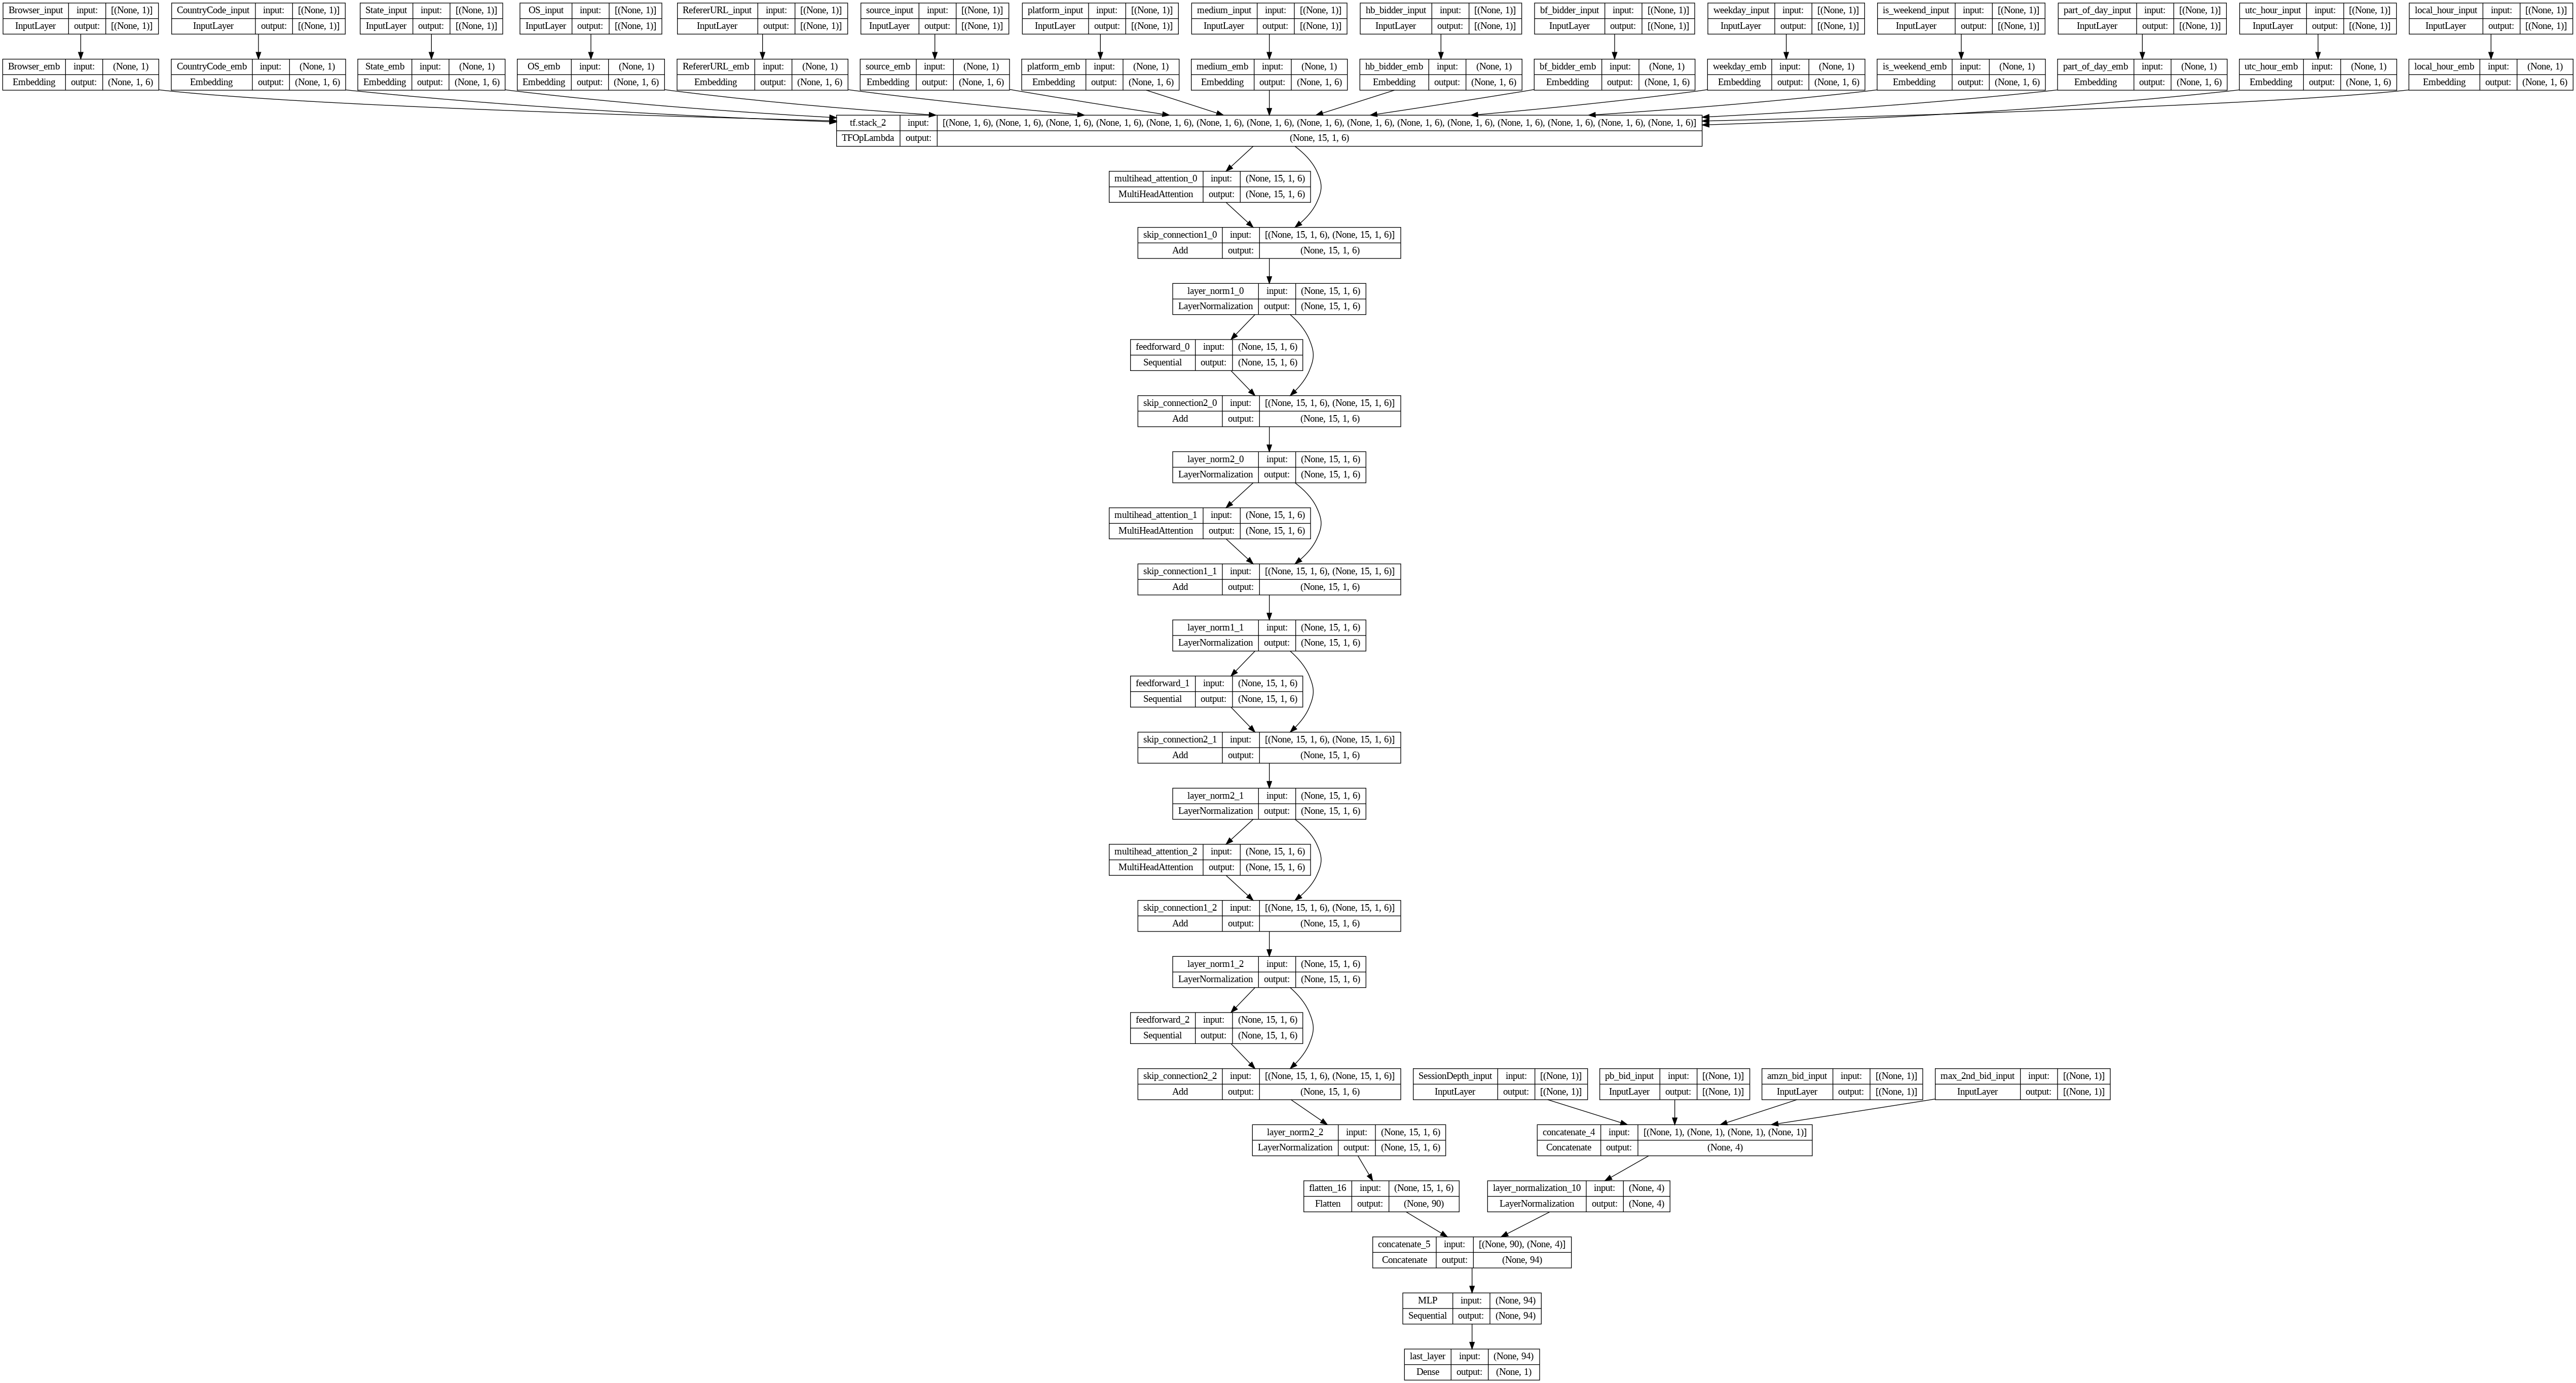

In [98]:
model_img_file = 'model.png'
keras.utils.plot_model(model, to_file=model_img_file, show_shapes=True)

In [99]:

# Compile the model
learning_rate = 0.0001
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
experiment.log_parameter("learning_rate", learning_rate)

In [100]:
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath='model_epoch_{epoch:02d}.h5', save_freq='epoch')


In [106]:
tf.debugging.disable_traceback_filtering()

In [107]:

# Train the model
epochs = 8
X_categorical = [train_features[cat].values for cat in categorical]
X_numeric = [train_features[cat].values for cat in numeric_features_scale] 
y = train_labels
model.fit(X_categorical + X_numeric, y, 
          epochs=epochs, batch_size=64, verbose=1, validation_freq=0.2, callbacks=[checkpoint_callback])

experiment.log_parameter("epochs", epochs)

Epoch 1/8


TypeError: ignored

In [48]:
# # Evaluate the model
# test_loss = model.evaluate(test_features, test_labels)
# print('Test Loss:', test_loss)

In [49]:
from sklearn.metrics import mean_squared_error
X_categorical_test = [test_features[cat].values for cat in categorical]
X_numeric_test = test_features[numeric_features_scale].values

y_pred = model.predict(X_categorical_test + [X_numeric_test])
mse = mean_squared_error(y_pred, test_labels)
print(mse)
experiment.log_metric('mse before inverse_transform', mse)

16704/16704 [==============================] - 37s 2ms/step
0.3121153112607021


In [50]:
test_labels[:10]

164923    0.179687
18439    -0.495438
89295     0.429901
136925    1.983028
222253    0.601218
954384   -0.558555
345329   -0.604766
1805     -0.270021
142422   -0.508964
605117   -0.235081
Name: bid_sc, dtype: float64

In [51]:
y_pred[:10]

array([[-0.3803083 ],
       [-0.46702072],
       [ 0.5263295 ],
       [ 2.4755518 ],
       [ 0.54801023],
       [-0.51428676],
       [-0.52660763],
       [-0.3008652 ],
       [-0.46939325],
       [-0.01557714]], dtype=float32)

In [52]:
test_full_df = test_features
# test_full_df['y_pred_deep'] = y_pred
test_full_df['y_pred_deep'] = scaler_y.inverse_transform(y_pred)
# test_full_df['y_pred_deep'] = scaler_y.inverse_transform(y_pred).squeeze() * np.maximum(test_data['max_2nd_bid'], 0.0001)
# test_full_df['bid'] = test_data['bid']
test_full_df['bid'] = scaler_y.inverse_transform(test_labels.values.reshape(-1, 1))


<ipython-input-52-b9d2a0a62250>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_full_df['y_pred_deep'] = y_pred
<ipython-input-52-b9d2a0a62250>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_full_df['bid'] = scaler_y.inverse_transform(test_labels.values.reshape(-1, 1))


In [53]:

# test_full_df[numeric_features] = scaler.inverse_transform(test_full_df[numeric_features])


In [54]:

for col, encoder in le.items():
  test_full_df[col] = encoder.inverse_transform(test_full_df[col])


<ipython-input-54-91b8fee747ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_full_df[col] = encoder.inverse_transform(test_full_df[col])
<ipython-input-54-91b8fee747ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_full_df[col] = encoder.inverse_transform(test_full_df[col])
<ipython-input-54-91b8fee747ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [55]:
# define groups and sizes

source_cat = {
    'google' : ['google'],
    'facebook' : ['facebook'],
    'outbrain' : ['outbrain', 'Other', "pinterest"]
}
sizes = ['high', 'low']

def read_data_grouped(dir_name):
    test_df = {value : {group_name : pd.read_csv(f'{dir_name}/sampled_1M_{value}_{group_name}_test.csv.gz', low_memory=False) for group_name in source_cat.keys()} for value in sizes}
    return test_df

group_df = read_data_grouped('/content')

In [56]:
concat_test_df = pd.concat([group_df[value][group_name] for value in sizes for group_name in source_cat])


In [57]:
concat_test_df['epoch'] = concat_test_df['EventTimeUsec2'] // 1000000

In [58]:
concat_test_df.loc[concat_test_df['CountryCode'] == 'us', 'State'] = concat_test_df.loc[concat_test_df['CountryCode'] == 'us', 'Region']
concat_test_df.loc[concat_test_df['CountryCode'] != 'us', 'State'] = 'unknown'

In [59]:
concat_test_df = concat_test_df.loc[~((concat_test_df['CountryCode'] == 'us') & ~(concat_test_df['State'].isin(us_state_tz['state']))), :]

In [60]:
concat_test_df = time_features(concat_test_df)

In [61]:
concat_test_df = concat_test_df.fillna("0")

In [62]:
concat_test_df = concat_test_df[~(concat_test_df['Browser'].isin(['wechat','puffin','waterfox']))]
concat_test_df = concat_test_df[~(concat_test_df['CountryCode'].isin(["cv", 'sl']))]
concat_test_df = concat_test_df[~(concat_test_df['RefererURL'].isin(['epiqlife.com', 'thesweetpaprika.com', 'lifelistener.com']))]

In [63]:
concat_test_df[categorical+numeric_features].shape

(1611443, 19)

In [64]:
concat_test_df[numeric_features] = scaler.transform(concat_test_df[numeric_features])
# concat_test_df['bid'] = scaler_y.transform(concat_test_df['bid'].values.reshape(-1, 1))

for col, encoder in le.items():
  print(col)
  concat_test_df[col] = encoder.transform(concat_test_df[col])



Browser
CountryCode
State
OS
RefererURL
source
platform
medium
hb_bidder
bf_bidder
weekday
is_weekend
part_of_day
utc_hour
local_hour


In [65]:
concat_test_df

,index,EventTimeUsec2,SessionDepth,Region,RefererURL,platform,source_medium,OS,Browser,CountryCode,...,max_2nd_bid,source,medium,epoch,State,local_hour,weekday,is_weekend,part_of_day,utc_hour
0,157,1682221905057877,-0.227352,Alabama,29,1,google/paid,0,6,195,...,1.201253,2,3,1682221905,0,21,2,1,3,3
1,240,1682224791012949,-0.682963,Nevada,29,1,google/paid,0,6,195,...,5.170177,2,3,1682224791,28,20,2,1,3,4
2,294,1682125907543444,0.130628,Alabama,29,1,google/paid,4,12,195,...,1.146130,2,3,1682125907,0,19,1,1,3,1
3,303,1682279914490941,-0.390070,Ontario,48,1,google/paid,0,6,33,...,2.487479,2,3,1682279914,53,17,2,1,2,19
4,434,1682111915330148,-0.455158,Limerick,29,1,google/paid,0,6,87,...,1.678994,2,3,1682111915,53,22,0,0,3,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250285,681056,1682192371424239,-0.162265,England,87,1,outbrain3/paid,0,6,65,...,-0.213594,3,3,1682192371,53,20,1,1,3,19
250286,681140,1682282530549083,-0.357527,Florida,41,1,outbrain1/paid,0,9,195,...,0.319271,3,3,1682282530,9,15,2,1,2,20
250287,681702,1682186934602556,-0.422614,Metropolitan City of Milan,102,1,outbrain19/paid,0,6,95,...,-0.287093,3,3,1682186934,53,20,1,1,3,18
250288,681777,1682268969605636,0.065541,Missouri,48,0,outbrain/paid,9,9,195,...,-0.268718,3,3,1682268969,25,10,2,1,1,16


In [66]:
concat_test_df_X_cat = [concat_test_df[cat].values for cat in categorical]
concat_test_df_X_numeric = concat_test_df[numeric_features].values

y_pred_deep = model.predict(concat_test_df_X_cat + [concat_test_df_X_numeric])

# concat_test_df['y_pred_deep'] = y_pred_deep
# concat_test_df['y_pred_deep'] = scaler_y.inverse_transform(y_pred_deep).squeeze() * np.maximum(concat_test_df['max_2nd_bid'], 0.0001)
concat_test_df['y_pred_deep'] = scaler_y.inverse_transform(y_pred_deep)
concat_test_df[numeric_features] = scaler.inverse_transform(concat_test_df[numeric_features])
# concat_test_df['bid'] = scaler_y.inverse_transform(concat_test_df['bid'].values.reshape(-1, 1))

for col, encoder in le.items():
  concat_test_df[col] = encoder.inverse_transform(concat_test_df[col])



50358/50358 [==============================] - 121s 2ms/step


In [85]:
from sklearn.metrics import mean_squared_error
test_full_df['max_2nd_bid'] = test_data['max_2nd_bid']
mse_for_comper = {}
for value in sizes:
    for group_name, group in source_cat.items():
        if value == 'high':
            size_cond = (test_full_df['max_2nd_bid'] > 0.9)
        else:
            size_cond = (test_full_df['max_2nd_bid'] <= 0.9)
        mse_for_comper[f'{value}_{group_name}'] = mean_squared_error(test_full_df[(test_full_df['source'].isin(group)) & (size_cond)]['bid'],
                                                                 test_full_df[(test_full_df['source'].isin(group)) & (size_cond)][f'y_pred_deep'])
mse_for_comper

<ipython-input-85-f36297b25eb6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_full_df['max_2nd_bid'] = test_data['max_2nd_bid']


{'high_google': 1.733138327114848,
 'high_facebook': 1.381578196357719,
 'high_outbrain': 1.322718989197421,
 'low_google': 0.13631767323088687,
 'low_facebook': 0.07925122351514,
 'low_outbrain': 0.11329628118230273}

In [68]:
from sklearn.metrics import mean_squared_error
mse_for_comper = {}
for value in sizes:
    for group_name, group in source_cat.items():
        if value == 'high':
            size_cond = (concat_test_df['max_2nd_bid'] > 0.9)
        else:
            size_cond = (concat_test_df['max_2nd_bid'] <= 0.9)
        mse_for_comper[f'{value}_{group_name}'] = mean_squared_error(concat_test_df[(concat_test_df['source'].isin(group)) & (size_cond)]['bid'],
                                                                 concat_test_df[(concat_test_df['source'].isin(group)) & (size_cond)][f'y_pred_deep'])


In [69]:

prefix = 'concat_test_df'
experiment.log_metrics(mse_for_comper, prefix=prefix)
mse_for_comper

{'high_google': 2.342582836926656,
 'high_facebook': 2.198662887950449,
 'high_outbrain': 2.421667928675591,
 'low_google': 0.15412892954716523,
 'low_facebook': 0.08013740859866605,
 'low_outbrain': 0.1810138563461111}

In [70]:
test_full_df.columns

Index(['Browser', 'CountryCode', 'State', 'OS', 'RefererURL', 'source',
       'platform', 'medium', 'hb_bidder', 'bf_bidder', 'weekday', 'is_weekend',
       'part_of_day', 'utc_hour', 'local_hour', 'SessionDepth_sc', 'pb_bid_sc',
       'amzn_bid_sc', 'max_2nd_bid_sc', 'y_pred_deep', 'bid', 'max_2nd_bid'],
      dtype='object')

In [71]:
# from sklearn.metrics import mean_squared_error
# mse_for_comper = {}
# for value in sizes:
#     for group_name, group in source_cat.items():
#         if value == 'high':
#             size_cond = (test_full_df['amzn_bid'] > 0.9) | (test_full_df['pb_bid'] > 0.9)
#         else:
#             size_cond = (test_full_df['amzn_bid'] <= 0.9) & (test_full_df['pb_bid'] <= 0.9)
#         if len(test_full_df[(test_full_df['source'] == group_name) & (size_cond)]) == 0:
#           print(group_name, value)
#           continue
#         mse_for_comper[f'{value}_{group_name}'] = mean_squared_error(test_full_df[(test_full_df['source'].isin(group)) & (size_cond)]['bid'],
#                                                                  test_full_df[(test_full_df['source'].isin(group)) & (size_cond)][f'y_pred_deep'])


In [72]:

# prefix = 'test_df'
# experiment.log_metrics(mse_for_comper, prefix=prefix)
# mse_for_comper

In [73]:
hetro_features_list = ['source', 'Browser', 'CountryCode', 'OS', 'RefererURL', 'platform']
hetro_features  = {feature: test_features[feature].value_counts(normalize=True) for feature in hetro_features_list}
hetro_features  = {feature: vc[vc > 0.01] for feature, vc in hetro_features.items()}
hetro_features  = {feature: vc.index.tolist() for feature, vc in hetro_features.items()}

In [74]:
embedding_layer = model.get_layer('CountryCode_emb')
embedding_weights = embedding_layer.get_weights()[0]
unique_countries = test_features["CountryCode"].unique()
country_indices  = dict(zip(unique_countries, le['CountryCode'].transform(unique_countries)))
embeddings_of_interest = [embedding_weights[country_indices[country]] for country in country_indices]
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(embeddings_of_interest)
similarity_df = pd.DataFrame(similarity_matrix, index=country_indices, columns=country_indices)
similarity_df.loc[['us', 'ca', 'mx', 'cl', 'uy', 'fr', 'es', 'gb'], ['us', 'ca', 'mx', 'cl', 'uy','fr','es', 'gb']]

,us,ca,mx,cl,uy,fr,es,gb
us,1.000000,0.554979,-0.675508,-0.699149,-0.814530,-0.765715,-0.690407,-0.160574
ca,0.554979,1.000000,-0.451182,-0.479811,-0.446790,-0.561839,-0.428617,0.415311
mx,-0.675508,-0.451182,1.000000,0.982646,0.871984,0.756326,0.979076,-0.015789
cl,-0.699149,-0.479811,0.982646,1.000000,0.883320,0.827748,0.989198,-0.030592
uy,-0.814530,-0.446790,0.871984,0.883320,1.000000,0.866624,0.905431,0.145978
fr,-0.765715,-0.561839,0.756326,0.827748,0.866624,1.000000,0.798253,0.235482
es,-0.690407,-0.428617,0.979076,0.989198,0.905431,0.798253,1.000000,-0.018082
gb,-0.160574,0.415311,-0.015789,-0.030592,0.145978,0.235482,-0.018082,1.000000


In [75]:
similarity_df.loc[hetro_features['CountryCode'], hetro_features['CountryCode']]

,us,ca,br,hu,gb,jp,mx,au,ar,fr,es,cl,co,de,za,it,ph,nz,ie
us,1.000000,0.554979,-0.795160,-0.415072,-0.160574,-0.629296,-0.675508,0.324515,-0.819046,-0.765715,-0.690407,-0.699149,-0.764584,-0.529321,-0.754461,-0.696458,-0.830497,0.575411,-0.105580
ca,0.554979,1.000000,-0.508427,-0.281829,0.415311,-0.592320,-0.451182,0.467714,-0.518524,-0.561839,-0.428617,-0.479811,-0.531118,-0.252119,-0.321442,-0.417498,-0.535752,0.539996,-0.280482
br,-0.795160,-0.508427,1.000000,0.764684,0.127151,0.792106,0.942441,-0.516144,0.988772,0.862170,0.915104,0.932315,0.986177,0.288592,0.833593,0.969015,0.986991,-0.644333,0.468673
hu,-0.415072,-0.281829,0.764684,1.000000,-0.230344,0.635312,0.898290,-0.340490,0.761070,0.474457,0.860208,0.862976,0.806993,0.275375,0.668308,0.849911,0.719369,-0.337396,0.789264
gb,-0.160574,0.415311,0.127151,-0.230344,1.000000,-0.116921,-0.015789,-0.038302,0.126513,0.235482,-0.018082,-0.030592,0.001339,-0.061263,0.088253,0.083914,0.117864,-0.141235,-0.489285
jp,-0.629296,-0.592320,0.792106,0.635312,-0.116921,1.000000,0.682648,-0.589250,0.755611,0.765797,0.658492,0.731153,0.787601,0.132459,0.697408,0.793876,0.775563,-0.391888,0.705380
mx,-0.675508,-0.451182,0.942441,0.898290,-0.015789,0.682648,1.000000,-0.349869,0.950889,0.756326,0.979076,0.982646,0.952870,0.408080,0.819169,0.968962,0.910656,-0.517579,0.555830
au,0.324515,0.467714,-0.516144,-0.340490,-0.038302,-0.589250,-0.349869,1.000000,-0.448711,-0.310975,-0.235011,-0.266035,-0.503404,0.464906,-0.117987,-0.388282,-0.547206,0.797885,-0.372681
ar,-0.819046,-0.518524,0.988772,0.761070,0.126513,0.755611,0.950889,-0.448711,1.000000,0.883671,0.947412,0.951339,0.983595,0.343013,0.879785,0.966920,0.987440,-0.642244,0.408543
fr,-0.765715,-0.561839,0.862170,0.474457,0.235482,0.765797,0.756326,-0.310975,0.883671,1.000000,0.798253,0.827748,0.834472,0.333014,0.859097,0.848946,0.863692,-0.470686,0.233237


In [76]:

embedding_layer = model.get_layer('Browser_emb')
embedding_weights = embedding_layer.get_weights()[0]
unique_browser  = test_features["Browser"].unique()
browser_indices  = dict(zip(unique_browser, le['Browser'].transform(unique_browser)))
embeddings_of_interest = [embedding_weights[browser_indices[browser]] for browser in browser_indices]
similarity_matrix = cosine_similarity(embeddings_of_interest)
similarity_df = pd.DataFrame(similarity_matrix, index=browser_indices, columns=browser_indices)
similarity_df.loc[hetro_features["Browser"], hetro_features["Browser"]]

,facebook,chrome,mobile safari,gsa,edge,safari,samsung browser,instagram
facebook,1.000000,0.211879,0.014628,0.282384,0.689559,0.906905,0.989742,0.979173
chrome,0.211879,1.000000,0.650804,0.902804,0.247182,-0.216406,0.132533,0.092321
mobile safari,0.014628,0.650804,1.000000,0.890116,0.615304,-0.303111,-0.126997,-0.187553
gsa,0.282384,0.902804,0.890116,1.000000,0.584868,-0.126542,0.161390,0.105461
edge,0.689559,0.247182,0.615304,0.584868,1.000000,0.544488,0.588974,0.544494
safari,0.906905,-0.216406,-0.303111,-0.126542,0.544488,1.000000,0.936865,0.945954
samsung browser,0.989742,0.132533,-0.126997,0.161390,0.588974,0.936865,1.000000,0.998118
instagram,0.979173,0.092321,-0.187553,0.105461,0.544494,0.945954,0.998118,1.000000


In [77]:
import json
import os 
dir_name = 'emb'
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
for cat in categorical: 
  print(cat)
  embedding_layer = model.get_layer(f'{cat}_emb')
  embedding_weights = embedding_layer.get_weights()[0]
  uniques  = test_features[cat].unique()
  uniques_lbl_dict  = dict(zip(uniques, le[cat].transform(uniques)))
  embeddings_of_interest = {str(val) : embedding_weights[uniques_lbl_dict[val]].tolist() for val in uniques_lbl_dict}
  with open(f'{dir_name}/{cat}_emb.json', "w") as f:
      json.dump(embeddings_of_interest, f, indent=4)
    
!zip -r /content/$dir_name/00emb.zip /content/$dir_name


Browser
CountryCode
State
OS
RefererURL
source
platform
medium
hb_bidder
bf_bidder
weekday
is_weekend
part_of_day
utc_hour
local_hour
updating: content/emb/ (stored 0%)
updating: content/emb/part_of_day_emb.json (deflated 55%)
updating: content/emb/source_emb.json (deflated 56%)
updating: content/emb/is_weekend_emb.json (deflated 41%)
updating: content/emb/medium_emb.json (deflated 51%)
updating: content/emb/.ipynb_checkpoints/ (stored 0%)
updating: content/emb/weekday_emb.json (deflated 52%)
updating: content/emb/hb_bidder_emb.json (deflated 63%)
updating: content/emb/platform_emb.json (deflated 51%)
updating: content/emb/Browser_emb.json (deflated 63%)
updating: content/emb/bf_bidder_emb.json (deflated 37%)
updating: content/emb/State_emb.json (deflated 64%)
updating: content/emb/RefererURL_emb.json (deflated 64%)
updating: content/emb/utc_hour_emb.json (deflated 67%)
updating: content/emb/local_hour_emb.json (deflated 67%)
updating: content/emb/OS_emb.json (deflated 58%)
updating: c

In [78]:
len(categorical)

15

In [79]:
def hetro(df, col, pred_col, true_col):
    from tqdm import tqdm
    hetro_dict = {}
    val_low_data = []
    for val in tqdm(df[col].unique()):
        if len(df[df[col] == val]) / len(df) < 0.01:
            val_low_data.append(val)
            continue
        hetro_dict[val] = mean_squared_error(df[df[col] == val][true_col], df[df[col] == val][pred_col])
    if val_low_data:
        print(f"low data for {col}: {val_low_data}")
    return hetro_dict

In [80]:
concat_test_df.columns

Index(['index', 'EventTimeUsec2', 'SessionDepth', 'Region', 'RefererURL',
       'platform', 'source_medium', 'OS', 'Browser', 'CountryCode',
       'mb_site_id', 'mbid', 'hb_bidder', 'pb_bid', 'amzn_bid', 'bf_bidder',
       'bid', 'max_2nd_bid', 'source', 'medium', 'epoch', 'State',
       'local_hour', 'weekday', 'is_weekend', 'part_of_day', 'utc_hour',
       'y_pred_deep'],
      dtype='object')

In [81]:
prefix = 'low'

for col in concat_test_df.columns:
    if concat_test_df[col].nunique() > 50:
      continue
    hetro_dict = hetro(concat_test_df[concat_test_df['max_2nd_bid'] <= 0.9], col, 'y_pred_deep', 'bid')
    print(col, ": \n", hetro_dict)
    experiment.log_metrics(hetro_dict, prefix=f'{prefix}_{col}')

100%|██████████| 4/4 [00:01<00:00,  3.26it/s]


low data for platform: ['smarttv']
platform : 
 {'mobile': 0.13473374830685397, 'tablet': 0.11172311768182419, '0': 0.1559844220977965}


100%|██████████| 8/8 [00:01<00:00,  5.06it/s]


low data for OS: ['chromium os', 'linux', 'ubuntu', 'firefox os']
OS : 
 {'android': 0.15969904569392354, 'ios': 0.08476173881418908, 'windows': 0.18702888203385173, 'mac os': 0.10433574150881966}


100%|██████████| 26/26 [00:03<00:00,  7.76it/s]


low data for Browser: ['firefox', 'silk', 'whale', 'chrome webview', 'android browser', 'miui browser', 'line', 'opera', 'oculus browser', '0', 'yandex', 'vivaldi', 'avast secure browser', 'mozilla', 'ucbrowser', 'icedragon', 'opera touch']
Browser : 
 {'chrome': 0.19418999851606358, 'mobile safari': 0.14876024655984282, 'facebook': 0.07755973669197677, 'samsung browser': 0.10947671466358927, 'gsa': 0.08774701169250489, 'edge': 0.20039092909581654, 'safari': 0.12023946347487849, 'webkit': 0.03824645290090686, 'instagram': 0.24666943201590258}


100%|██████████| 26/26 [00:06<00:00,  3.88it/s]


low data for hb_bidder: ['stroeercore', 'richaudience', 'smartadserver', 'zeta_global_ssp', 'onetag', 'yieldmo', 'sonobi', 'sharethrough']
hb_bidder : 
 {'kueezrtb': 0.12423964491755633, 'yahoossp': 0.1441692829077698, 'ix': 0.1209310824795881, 'criteo': 0.1775869726895171, 'sovrn': 0.0931109362561117, 'rubicon': 0.1084561479962717, 'grid': 0.07627139392900752, '0': 0.23284381292522982, 'adyoulike': 0.16203053978610468, 'appnexusast': 0.11396020279805084, 'openx': 0.10327556961401277, 'improvedigital': 0.049057715160967644, 'teads': 0.08621078152007072, 'vidazoo': 0.13160136968479855, 'triplelift': 0.1160220270988074, 'medianet': 0.17436222135166182, 'pubmatic': 0.11136260579193269, 'minutemedia': 0.32315022584934094}


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


bf_bidder : 
 {'adx': 0.11199307157667239, 'ebda': 0.36156245157436206}


100%|██████████| 5/5 [00:01<00:00,  3.84it/s]


source : 
 {'google': 0.15412892954716523, 'facebook': 0.08013740859866605, 'outbrain': 0.24759819255057797, 'pinterest': 0.07816105903967889, 'Other': 0.21285988792797306}


100%|██████████| 5/5 [00:01<00:00,  3.52it/s]


medium : 
 {'paid': 0.13972995453774367, 'organic': 0.11188144242684205, 'unknown': 0.20276839840919542, 'affiliate': 0.07756900246325939, 'Other': 0.1564892579621872}


100%|██████████| 24/24 [00:02<00:00, 11.60it/s]


local_hour : 
 {13: 0.14957556591137602, 17: 0.14575828014307135, 20: 0.12286297609481943, 6: 0.14365330446931168, 19: 0.13527503901801483, 10: 0.20036469598377915, 21: 0.1069600927830517, 8: 0.17029101103342587, 2: 0.10823141252768587, 16: 0.11827815276014972, 18: 0.10806298106432852, 14: 0.11818367186393827, 11: 0.13130642245946195, 7: 0.14810677677297687, 12: 0.12826824400714112, 9: 0.12202964127912572, 0: 0.15437816454127087, 23: 0.15149218618401974, 22: 0.11731839683602294, 15: 0.14010828987125304, 5: 0.16153278363788995, 1: 0.09577154482430326, 4: 0.15579953388550447, 3: 0.14031873462550673}


100%|██████████| 3/3 [00:00<00:00,  4.81it/s]


weekday : 
 {5: 0.13207051055147198, 6: 0.1407598975571854, 4: 0.1449024075298187}


100%|██████████| 2/2 [00:00<00:00,  3.30it/s]


is_weekend : 
 {1.0: 0.13641728811783438, 0.0: 0.1449024075298187}


100%|██████████| 4/4 [00:00<00:00,  4.24it/s]


part_of_day : 
 {2: 0.13327854940062892, 3: 0.12280572903579055, 1: 0.15313581137173718, 0: 0.13660315448670257}


100%|██████████| 24/24 [00:02<00:00,  9.22it/s]


utc_hour : 
 {1: 0.1444791361558675, 15: 0.15208455138933685, 11: 0.16004708479962826, 2: 0.17098719833659165, 21: 0.12414334183118758, 19: 0.1115890255786182, 23: 0.15469304502138811, 8: 0.15088248628822257, 4: 0.1511707812410844, 20: 0.10639392500159504, 5: 0.1374576715229868, 9: 0.16977228693701152, 3: 0.1074191130489169, 17: 0.11545063876843331, 7: 0.13417113134979292, 12: 0.13707796188319032, 10: 0.109321057439053, 22: 0.13339503258201832, 13: 0.11388339477002955, 0: 0.1716745483308669, 18: 0.1297066037867577, 16: 0.10880632852684398, 6: 0.2246302432778465, 14: 0.11127603544473898}


In [82]:
prefix = 'high'

for col in concat_test_df.columns:
    if concat_test_df[col].nunique() > 50:
      continue
    hetro_dict = hetro(concat_test_df[concat_test_df['max_2nd_bid'] > 0.9], col, 'y_pred_deep', 'bid')
    print(col, ": \n", hetro_dict)
    experiment.log_metrics(hetro_dict, prefix=f'{prefix}_{col}')

100%|██████████| 4/4 [00:00<00:00,  4.14it/s]


low data for platform: ['smarttv']
platform : 
 {'mobile': 2.2145927632369773, '0': 2.634778553947395, 'tablet': 2.8044840220128044}


100%|██████████| 7/7 [00:01<00:00,  5.04it/s]


low data for OS: ['linux', 'ubuntu']
OS : 
 {'android': 2.3412310727432994, 'ios': 1.3817943386707525, 'windows': 2.9598880747554794, 'chromium os': 2.090365099250668, 'mac os': 2.7634104676147606}


100%|██████████| 20/20 [00:02<00:00,  8.54it/s]


low data for Browser: ['samsung browser', 'silk', 'opera', 'whale', 'instagram', 'webkit', 'firefox', 'line', 'miui browser', '0', 'slim', 'basilisk']
Browser : 
 {'chrome': 2.6018190841072615, 'gsa': 0.8513103502624113, 'mobile safari': 0.7972389066171378, 'facebook': 1.9868135319773939, 'safari': 1.8617555411342093, 'chrome webview': 1.6049854735891909, 'edge': 2.6043729401643527, 'android browser': 1.9398216543285292}


100%|██████████| 26/26 [00:05<00:00,  4.88it/s]


low data for hb_bidder: ['smartadserver', 'improvedigital', 'zeta_global_ssp', 'richaudience', 'stroeercore', 'yieldmo', 'sharethrough']
hb_bidder : 
 {'triplelift': 2.228688097262417, 'ix': 2.2393963157772414, 'medianet': 1.867080048787175, 'minutemedia': 2.614194592515194, 'rubicon': 1.9965492715246718, 'criteo': 3.600428999154888, 'onetag': 2.1833499502000713, 'teads': 1.241182026544313, 'kueezrtb': 1.818494216020456, 'pubmatic': 12.320425603624432, 'openx': 1.9722527491797055, '0': 6.058761097857563, 'adyoulike': 1.6395800582983777, 'yahoossp': 2.2034523156227075, 'grid': 2.011501003183679, 'appnexusast': 1.3075110439001256, 'vidazoo': 1.9300055355748438, 'sonobi': 2.0155727364479983, 'sovrn': 1.4220474809896317}


100%|██████████| 2/2 [00:01<00:00,  1.81it/s]


bf_bidder : 
 {'adx': 1.5331305353960623, 'ebda': 7.099310955147582}


100%|██████████| 5/5 [00:01<00:00,  4.22it/s]


source : 
 {'google': 2.342582836926656, 'facebook': 2.198662887950449, 'pinterest': 1.9292046804664966, 'outbrain': 2.542551675312092, 'Other': 1.8117805171928263}


100%|██████████| 5/5 [00:01<00:00,  4.66it/s]


low data for medium: ['organic']
medium : 
 {'paid': 2.354758113692935, 'unknown': 1.9587408674615328, 'affiliate': 2.0608159073825, 'Other': 1.6232325994900507}


100%|██████████| 24/24 [00:01<00:00, 13.93it/s]


local_hour : 
 {21: 2.4000460701236004, 20: 2.590191209643624, 19: 1.9831473935675088, 17: 1.9542448796479681, 22: 2.4808776383770077, 10: 2.38339462628023, 12: 2.423904612422643, 5: 2.621195312457456, 23: 2.1813990681266255, 13: 2.0422234159874346, 8: 2.7906801028814656, 9: 2.3479940226938187, 16: 2.261527317182231, 1: 2.4038779820589524, 18: 2.038081031001316, 7: 2.3089120202834357, 6: 2.1585023704594763, 14: 2.1079299844001302, 11: 2.5561443849619137, 3: 2.4103394420370816, 4: 2.638471479297906, 0: 2.2143035013900048, 2: 2.226243759786623, 15: 2.1828279569971656}


100%|██████████| 3/3 [00:00<00:00,  5.82it/s]


weekday : 
 {6: 2.4588401296302576, 5: 2.22571657830815, 4: 2.063967344629032}


100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


is_weekend : 
 {1.0: 2.3344379974727945, 0.0: 2.063967344629032}


100%|██████████| 4/4 [00:00<00:00,  6.81it/s]


part_of_day : 
 {3: 2.281897855991009, 2: 2.162581056031518, 1: 2.4302130677411444, 0: 2.4385687716348357}


100%|██████████| 24/24 [00:01<00:00, 13.94it/s]


utc_hour : 
 {3: 1.7903846970584822, 4: 2.6363261564088294, 1: 1.9208054957582201, 19: 2.468989009838448, 21: 1.93416484583942, 22: 2.6929186038023767, 17: 2.6591893632550065, 14: 2.235872087263479, 11: 2.446603396109749, 2: 1.9068135446270396, 18: 2.2085449629566427, 7: 2.7450654428868253, 13: 2.8805258309824056, 15: 2.2781543205246817, 20: 2.133863385352807, 16: 2.025393956624718, 0: 1.818388802533613, 12: 2.5393566038721596, 10: 3.0257905642568224, 9: 2.7682938648179722, 6: 2.673230895611119, 8: 2.6656184431098295, 5: 2.078844425984284, 23: 1.7128851142427652}


In [83]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/aviad-has/kueez-google-bid-deep/4366d085690c413f802669cbf0a89734
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [13364]           : (0.1846676468849182, 8.744368553161621)
COMET INFO:     concat_test_df_high_facebook : 2.198662887950449
COMET INFO:     concat_test_df_high_google   : 2.342582836926656
COMET INFO:     concat_test_df_high_outbrain : 2.421667928675591
COMET INFO:     concat_test_df_low_facebook  : 0.08013740859866605
COMET INFO:     concat_test_df_low_google    : 0.15412892954716523
COMET INFO:     concat_test_df_low_outbrain  : 0.1810138563461111
COMET INFO:     epoch_duration [4]           : 